<a href="https://colab.research.google.com/github/MariumAZ/DeepLab/blob/master/Neurocat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Tensorflow
import tensorflow as tf
print(tf.__version__)

# I/O libraries
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

# Helper libraries
import matplotlib
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import cv2 as cv
from tqdm import tqdm
import IPython
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

# Comment this out if you want to see Deprecation warnings
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

1.15.0


**TASK1**

To perform a segmenation task we can use a class named  'Deep' that  :



1.   Makes use of a path to a tensorflow frozen graph model 
2.   Runs inference on a given image after preprocessing it to fit into the       model 
3.   Has A mapper from labels to label names :
here we have 19 classes predefined : 
   ( 'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle', 'void')
4.   Has a  visualisation function that plots the result of semantic segmentation.



In this example we used MobileNetV2 

MobileNetV2 builds upon the ideas from MobileNetV1 [1], using depthwise separable convolution as efficient building blocks. However, V2 introduces two new features to the architecture:
 1) linear bottlenecks between the layers and 
 2) shortcut connections between the bottlenecks1. The basic structure is shown below. [1] (https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html)

![Texte alternatif…](https://miro.medium.com/max/1176/1*bqE59FvgpvoAQUMQ0WEoUA.png)






Code details :

1.   Importing the Frozen model : in a frozen model  weight variables have been replaced with constants so we can no longuer trained it .

To Do so : several steps are recquired : [2] https://medium.com/@hideyuki/how-do-you-classify-an-image-against-a-frozen-tensorflow-model-code-walk-through-of-9792a74f6ef9



1. Open the model file in the binary protobuf format      
2. Read data into a buffer
3. Convert to GraphDef object from data
4. Convert to Graph object from GraphDef object

![Texte alternatif…](https://miro.medium.com/max/1638/0*WE1Jk9F7WXc-R1mO.png)






In [0]:
class Deep(object):
    """Class to load deeplab model and run inference."""

    FROZEN_GRAPH_NAME = 'frozen_inference_graph'
    def __init__(self, tarball_path):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()
        graph_def = None

        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.GraphDef.FromString(file_handle.read()) 
                break
        tar_file.close()

        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')

        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')
        self.sess = tf.Session(graph=self.graph)
        for n in tf.get_default_graph().as_graph_def().node:
              print('name',n.name) 
        writer = tf.summary.FileWriter('./log/', self.sess.graph)      

    def run(self, image, INPUT_TENSOR_NAME = 'ImageTensor:0', OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'):
        """Runs inference on a single image.

        Args:
            image: A PIL.Image object, raw input image.
            INPUT_TENSOR_NAME: The name of input tensor, default to ImageTensor.
            OUTPUT_TENSOR_NAME: The name of output tensor, default to SemanticPredictions.

        Returns:
            resized_image: RGB image resized from original input image.
            seg_map: Segmentation map of `resized_image`.
        """
        width, height = image.size
        target_size = (2049,1025)  # size of Cityscapes images
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        print('resized_image',resized_image)

        batch_seg_map = self.sess.run(OUTPUT_TENSOR_NAME,feed_dict={INPUT_TENSOR_NAME: [np.asarray(resized_image)]})

        print('input', np.asarray(resized_image).shape)
        #print('batch :',batch_seg_map)
        seg_map = batch_seg_map[0]  # expected batch size = 1
        if len(seg_map.shape) == 2:
            seg_map = np.expand_dims(seg_map,-1)  # need an extra dimension for cv.resize
        seg_map = cv.resize(seg_map, (width,height), interpolation=cv.INTER_NEAREST)
        return seg_map

    def create_label_colormap(self):
        colormap = np.array([
        [128,  64, 128],
        [244,  35, 232],
        [ 70,  70,  70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170,  30],
        [220, 220,   0],
        [107, 142,  35],
        [152, 251, 152],
        [ 70, 130, 180],
        [220,  20,  60],
        [255,   0,   0],
        [  0,   0, 142],
        [  0,   0,  70],
        [  0,  60, 100],
        [  0,  80, 100],
        [  0,   0, 230],
        [119,  11,  32],
        [  0,   0,   0]], dtype=np.uint8)
        return colormap

    #Mapper function
    def mapper(self,label):

      if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

      colormap = self.create_label_colormap()

      if np.max(label) >= len(colormap):
        print('label',np.max(label))
        raise ValueError('label value too large.')
      return colormap[label]

 
    #plot function
    def plot_segmentation(self,image, seg_map):
   
     plt.figure(figsize=(20, 4))
     grid_spec = gridspec.GridSpec(1, 4,width_ratios=[6, 6, 6, 1])#width_ratios=[6, 6, 6, 1]
     #plot the input image 
     plt.subplot(grid_spec[0])
     plt.imshow(image)
     plt.axis('off')
     plt.title('input image')

     plt.subplot(grid_spec[1])
     seg_image = self.mapper(seg_map).astype(np.uint8)
     plt.imshow(seg_image)
     plt.axis('off')
     plt.title('segmentation map')

     plt.subplot(grid_spec[2])
     plt.imshow(image)
     plt.imshow(seg_image, alpha=0.7)
     plt.axis('off')
     plt.title('segmentation overlay')

     LABEL_NAMES = np.asarray([
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck',
    'bus', 'train', 'motorcycle', 'bicycle', 'void'])
     FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
     #[[0] [1] [2] [3]]
     print('FULL_LABEL_MAP: ',FULL_LABEL_MAP)
     FULL_COLOR_MAP = self.mapper(FULL_LABEL_MAP)
    # [[[128,  64, 128]] [[244,  35, 232]] [[ 70,  70,  70]] [[102, 102, 156]]]
     #print( 'FULL_COLOR_MAP',FULL_COLOR_MAP)
     unique_labels = np.unique(seg_map)
     #unique_labels=unique_labels[0:len(FULL_COLOR_MAP)]
     #print('unique labels :',unique_labels)
     #unique labels : [ 0  2  3  8  9 10 11 12 13 14 15 18]
     #print('unique :',len(unique_labels))
     ax = plt.subplot(grid_spec[3])
     #print(FULL_COLOR_MAP[unique_labels])
     plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
     ax.yaxis.tick_right()
     plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
     plt.xticks([], [])
     ax.tick_params(width=0.0)
     plt.grid('off')
     plt.show()  
   

In [0]:
MODEL_NAME = 'mobilenetv2_coco_cityscapes_trainfine'

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_cityscapes_trainfine':
        'deeplabv3_mnv2_cityscapes_train_2018_02_05.tar.gz',
    'xception65_cityscapes_trainfine':
        'deeplabv3_cityscapes_train_2018_02_06.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'
model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)
download_path = os.path.join(model_dir, _TARBALL_NAME)
print(download_path)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME], download_path)
print(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME], download_path)
print('download completed! loading DeepLab model...')
MODEL = Deep(download_path)
print('model loaded successfully!')

/tmp/tmp93_m5hsd/deeplab_model.tar.gz
downloading model, this might take a while...
http://download.tensorflow.org/models/deeplabv3_mnv2_cityscapes_train_2018_02_05.tar.gz /tmp/tmp93_m5hsd/deeplab_model.tar.gz
download completed! loading DeepLab model...
name zeros/shape_as_tensor
name zeros/Const
name zeros
name Variable
name Variable/Assign
name Variable/read
model loaded successfully!


Example image : 

In [0]:
S3=urllib.request.urlretrieve('https://github.com/MariumAZ/DeepLab/blob/master/1151816264.jpg.0.jpg?raw=true')[0]

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1200x800 at 0x7F23A0038780>
resized_image <PIL.Image.Image image mode=RGB size=2049x1025 at 0x7F23A0038B38>
input (1025, 2049, 3)
[[ 2  2  2 ...  2  2  2]
 [ 2  2  2 ...  2  2  2]
 [ 2  2  2 ...  2  2  2]
 ...
 [ 0  0  0 ...  0  0 11]
 [ 0  0  0 ...  0  0 11]
 [ 0  0  0 ...  0  0 11]]
FULL_LABEL_MAP:  [[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]
 [16]
 [17]
 [18]
 [19]]


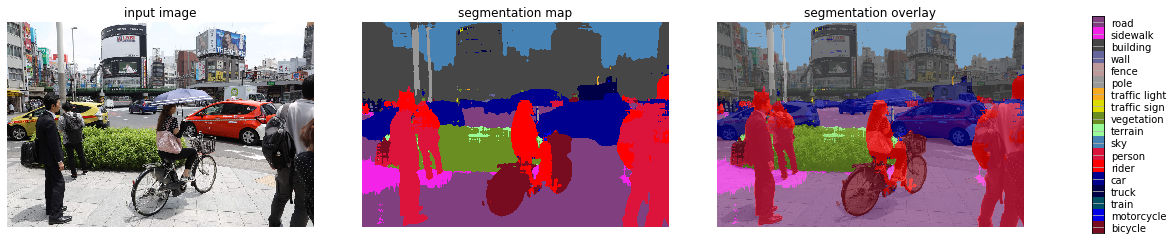

In [0]:
# Call the class 
def Result_segmentation(SAMPLE_IMAGE):
   # """Inferences DeepLab model and visualizes result."""
     original_im = Image.open(SAMPLE_IMAGE)
     print(original_im)
     seg_map = MODEL.run(original_im)
     print(seg_map)
     MODEL.plot_segmentation(original_im, seg_map)
Result_segmentation(S3) 

**TASK 2**

Generally, a segmentation network contains two parts: an encoder 
E
 and a decoder 
D

![Texte alternatif…](https://storage.googleapis.com/groundai-web-prod/media%2Fusers%2Fuser_293312%2Fproject_393246%2Fimages%2Ffigure%2Fpipeline_v7.png)
source : https://www.groundai.com/project/unrestricted-adversarial-attacks-for-semantic-segmentation/1

1/New attack method called Dense Adversary Generation 
(
D
A
G
)
, which generates a group of adversarial examples for a bunch of state-of-the-art segmentation and detection deep networks. However, all of the attack methods rely on norm-bounded perturbations, which only cover a small fraction of all the feasible adversarial examples.

